<a href="https://colab.research.google.com/github/sksaket/Assignment_forecasting/blob/main/Forecasting_airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

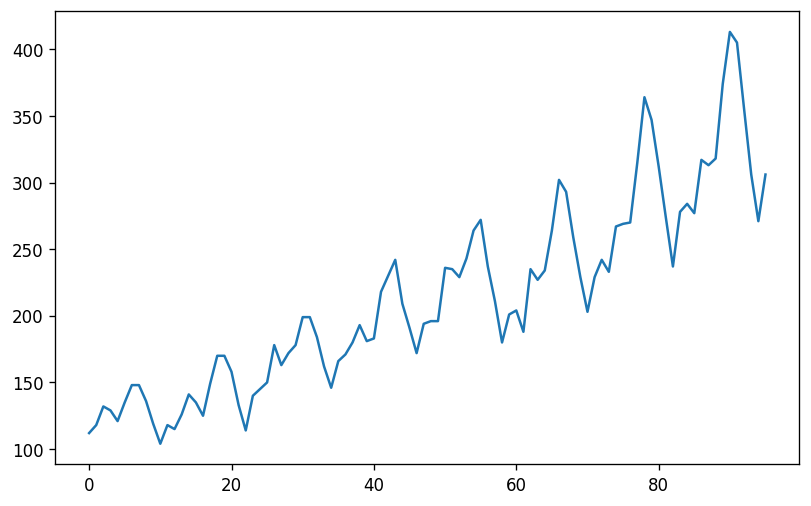

In [148]:
airlines=pd.read_excel("/content/Airlines+Data.xlsx")
airlines.columns
airlines.Passengers.plot() # seems like linear trend and multiplicative seasonality 
airlines.index=pd.to_datetime(airlines.Month,format="%b-%y")


In [149]:
airlines.rename(columns={'Month':'Date'},inplace=True)
airlines["Date"]=pd.to_datetime(airlines.Date,format="%b-%y")
airlines["Month"]=airlines.Date.dt.strftime("%b")
airlines["Year"]=airlines.Date.dt.strftime("%Y")


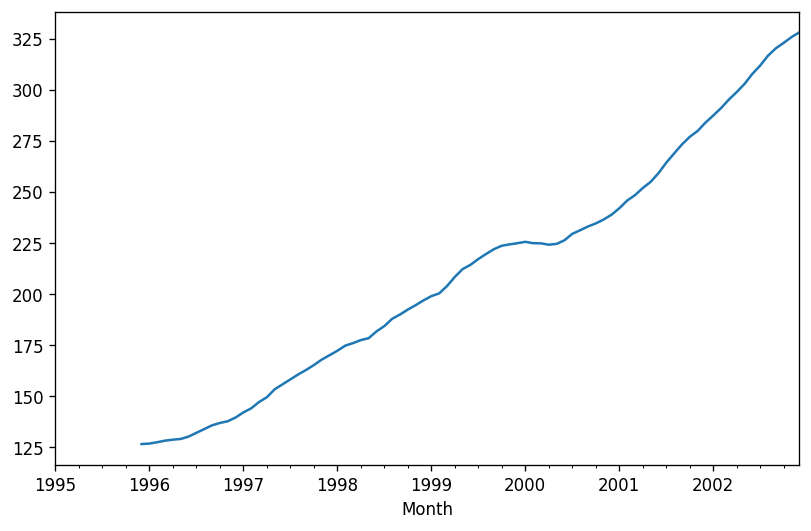

In [150]:
airlines.Passengers.rolling(12).mean().plot() # almost perfectly linear

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.12812093729688012

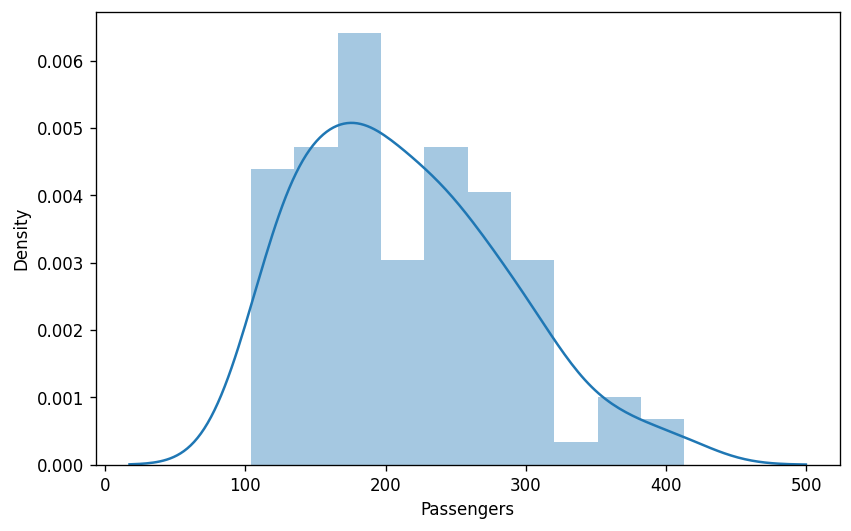

In [151]:
sns.distplot(airlines.Passengers,bins=10,kde=True) # positie skew, more cases of lower number of passengers
airlines.Passengers.skew() # 0.63
airlines.Passengers.kurt() # -0.12 no peakedness

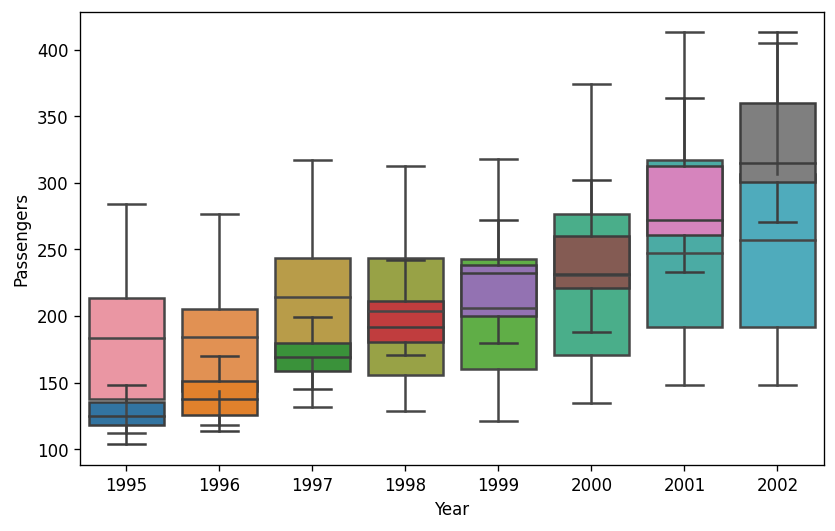

In [152]:
sns.boxplot(x='Month',y='Passengers',data=airlines) # more passengers in july and august 
sns.boxplot(x='Year',y='Passengers',data=airlines) # passengers increasing by the years

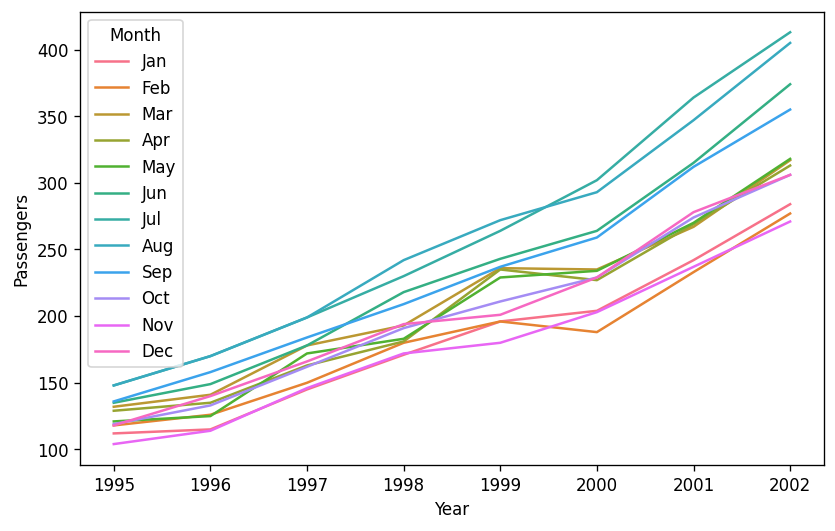

In [153]:
sns.lineplot(x='Year',y='Passengers',hue='Month',data=airlines) #more passengers in july,august, less in november, all increasing yearly

In [154]:
airlines["t"]=np.arange(1,97)
airlines["t_sq"]=airlines["t"]*airlines["t"]
airlines["log_Passengers"]=np.log(airlines["Passengers"])
m_dummies=pd.get_dummies(airlines['Month']) # 12 dummy variables for months
airlines=pd.concat([airlines,m_dummies],axis=1)

In [155]:
train=airlines.iloc[:72,:]
test=airlines.iloc[72:,:]

In [156]:
###### Model Based #######
import statsmodels.formula.api as smf
# --> Linear Model
lin_model=smf.ols('Passengers~t',data=train).fit()
lin_pred=lin_model.predict(test['t'])
lin_rmse=np.sqrt(np.mean((test.Passengers-lin_pred)**2))

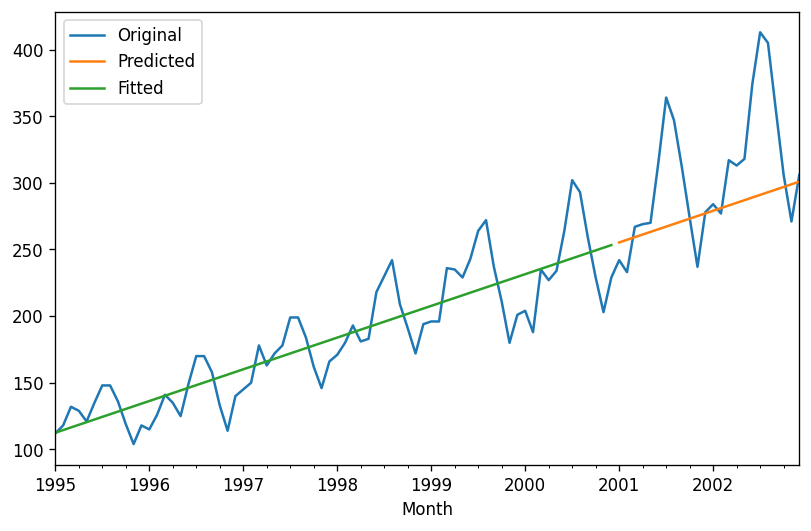

In [157]:
plt.rcParams.update({'figure.figsize':(8,5),'figure.dpi':120})
airlines.Passengers.plot(label='Original',legend=True)
lin_pred.plot(label='Predicted',legend=True)
lin_model.fittedvalues.plot(label='Fitted',legend=True)

In [158]:
# --> Quadratic Model
qua_model=smf.ols('Passengers~t+t_sq',data=train).fit()
qua_pred=qua_model.predict(test[['t','t_sq']])
qua_rmse=np.sqrt(np.mean((test.Passengers-qua_pred)**2))

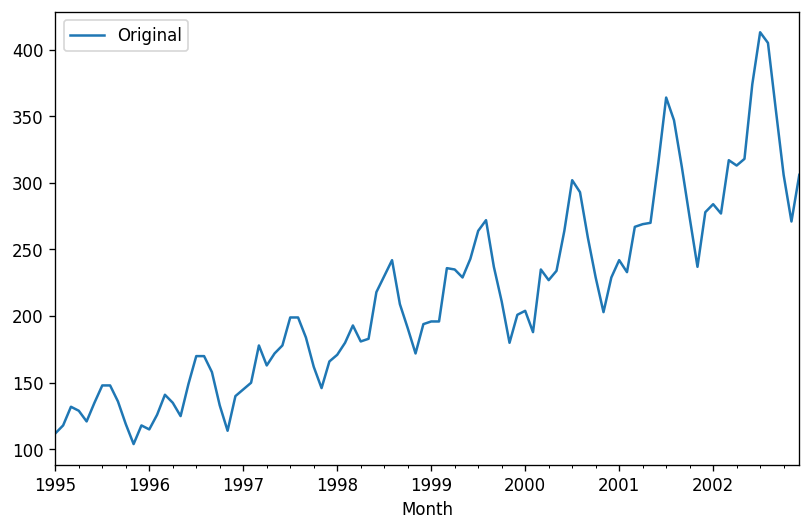

In [159]:
airlines.Passengers.plot(label='Original',legend=True)

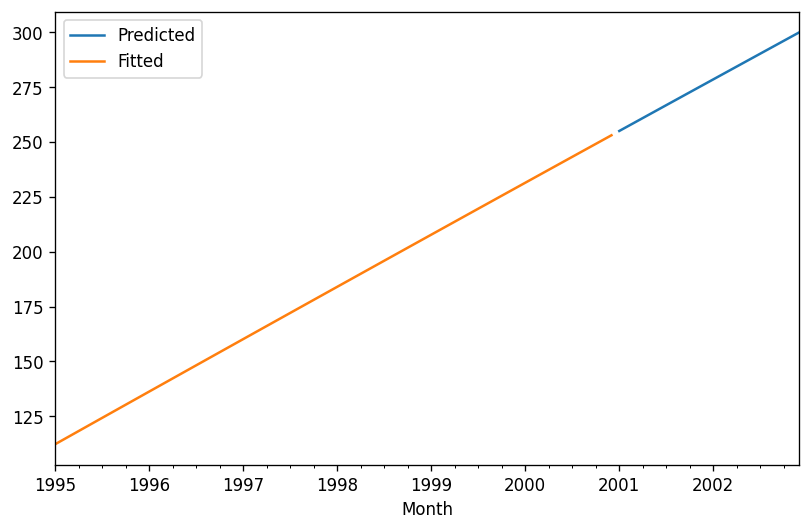

In [160]:
qua_pred.plot(label='Predicted',legend=True)
qua_model.fittedvalues.plot(label='Fitted',legend=True)

In [161]:
# --> Exponential Model
exp_model=smf.ols('log_Passengers~t',data=train).fit()
exp_pred=exp_model.predict(test['t'])
exp_rmse=np.sqrt(np.mean((test.Passengers-np.exp(exp_pred))**2))

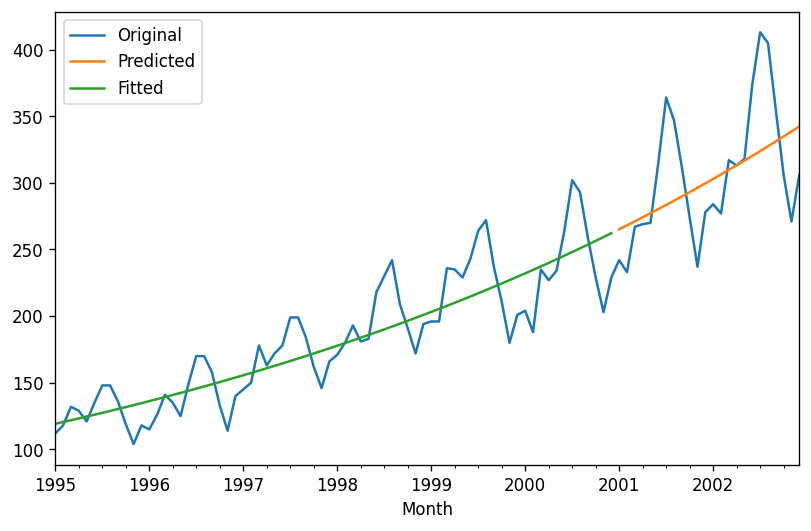

In [162]:
airlines.Passengers.plot(label='Original',legend=True)
np.exp(exp_pred).plot(label='Predicted',legend=True)
np.exp(exp_model.fittedvalues).plot(label='Fitted',legend=True)


In [163]:
# --> Linear Model additive seasonality
list(airlines['Month'][:11])

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']

In [164]:
lin_add_model=smf.ols('Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov'
,data=train).fit()
# 11 dummy variables to represent the 12 months
lin_add_pred=lin_add_model.predict(test)
lin_add_rmse=np.sqrt(np.mean((test.Passengers-lin_add_pred)**2))

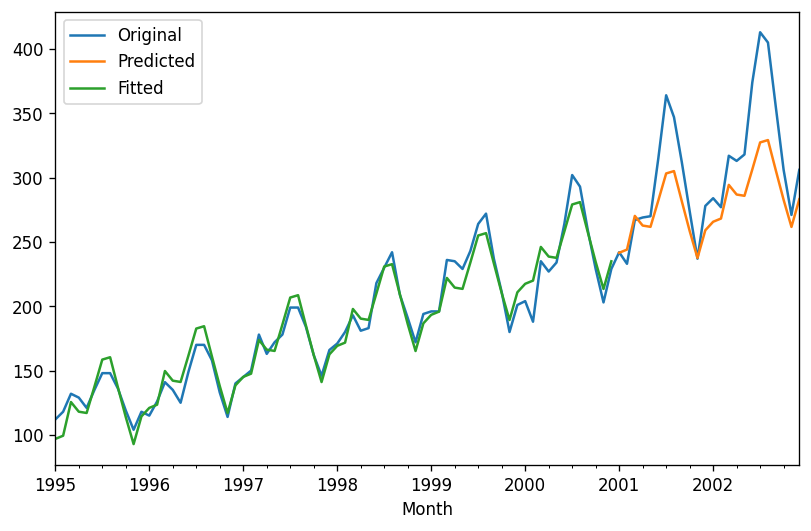

In [165]:
airlines.Passengers.plot(label='Original',legend=True)
lin_add_pred.plot(label='Predicted',legend=True)
lin_add_model.fittedvalues.plot(label='Fitted',legend=True)

In [166]:
# --> Linear Model multiplicative seasonality
lin_mul_model=smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
# 11 dummy variables to represent the 12 months
lin_mul_pred=lin_mul_model.predict(test)
lin_mul_rmse=np.sqrt(np.mean((test.Passengers-np.exp(lin_mul_pred))**2))

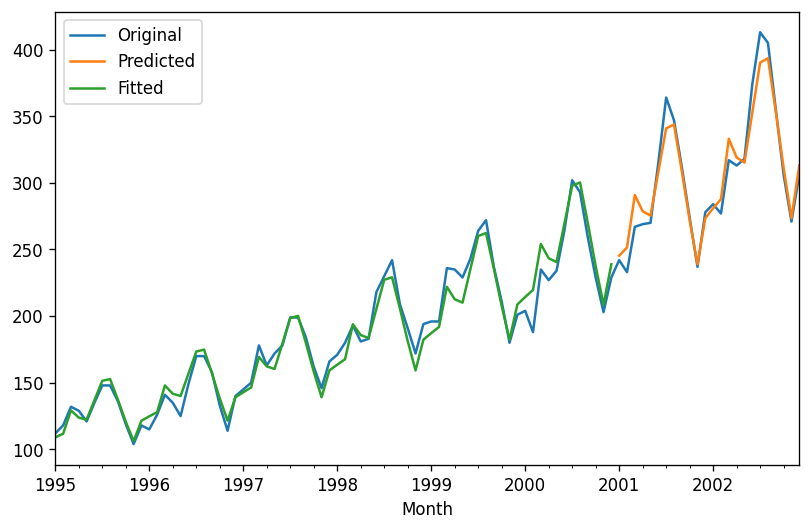

In [167]:
airlines.Passengers.plot(label='Original',legend=True)
np.exp(lin_mul_pred).plot(label='Predicted',legend=True)
np.exp(lin_mul_model.fittedvalues).plot(label='Fitted',legend=True)

In [168]:
# --> Quadratic Model additive seasonality
qua_add_model=smf.ols('Passengers~t+t_sq+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
# 11 dummy variables to represent the 12 months
qua_add_pred=qua_add_model.predict(test)
qua_add_rmse=np.sqrt(np.mean((test.Passengers-qua_add_pred)**2))

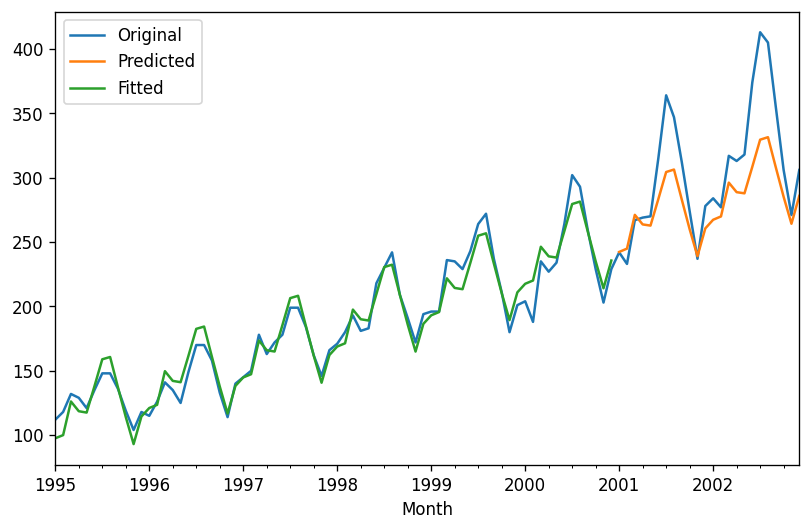

In [169]:
airlines.Passengers.plot(label='Original',legend=True)
qua_add_pred.plot(label='Predicted',legend=True)
qua_add_model.fittedvalues.plot(label='Fitted',legend=True)

In [170]:
# --> Quadratic Model multiplicative seasonality
qua_mul_model=smf.ols('log_Passengers~t+t_sq+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
# 11 dummy variables to represent the 12 months
qua_mul_pred=qua_mul_model.predict(test)
qua_mul_rmse=np.sqrt(np.mean((test.Passengers-np.exp(qua_mul_pred))**2))

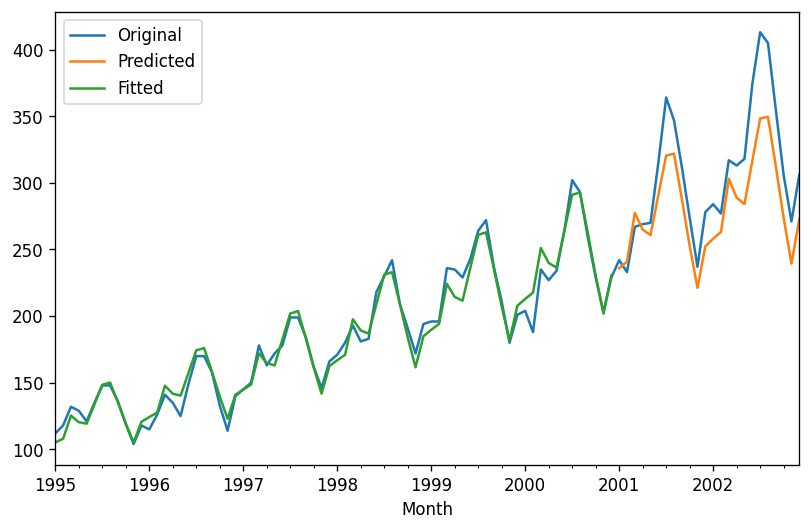

In [171]:
airlines.Passengers.plot(label='Original',legend=True)
np.exp(qua_mul_pred).plot(label='Predicted',legend=True)
np.exp(qua_mul_model.fittedvalues).plot(label='Fitted',legend=True)

In [172]:
rmse_dict={'Linear':lin_rmse,'Quadratic':qua_rmse,'Exponential':exp_rmse,'Linear Additive':lin_add_rmse,'Linear Multiplicative':lin_mul_rmse,'Quadratic Additive':qua_add_rmse,'Quadratic Multiplicative':qua_mul_rmse}
min(rmse_dict.values())


11.714670246780582

In [173]:
#Linear Model with Multiplicative seasonality can be used for max accuracy

In [174]:
# Data based approaches
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

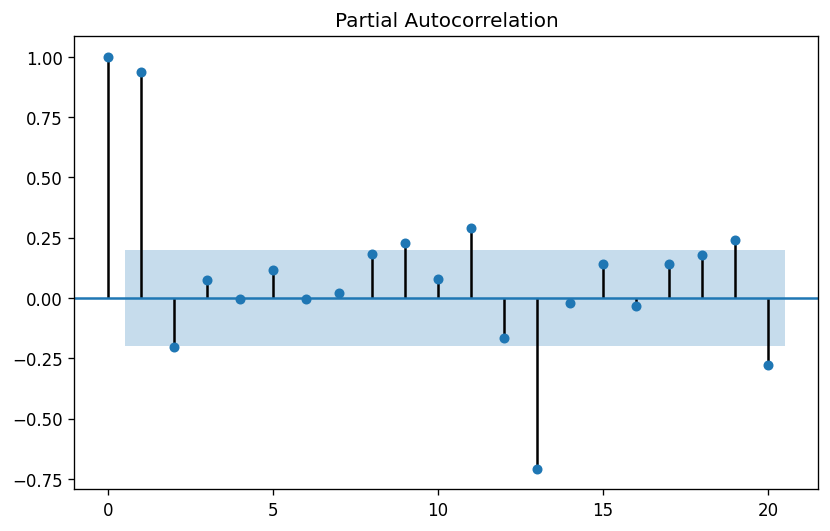

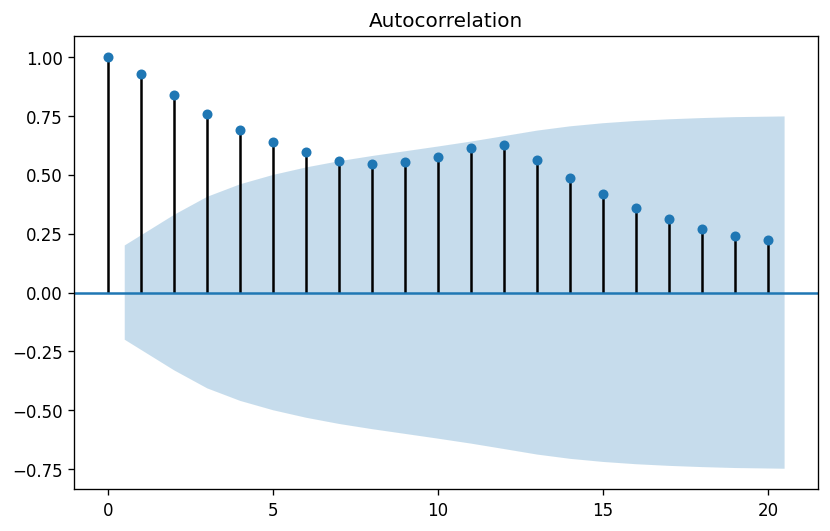

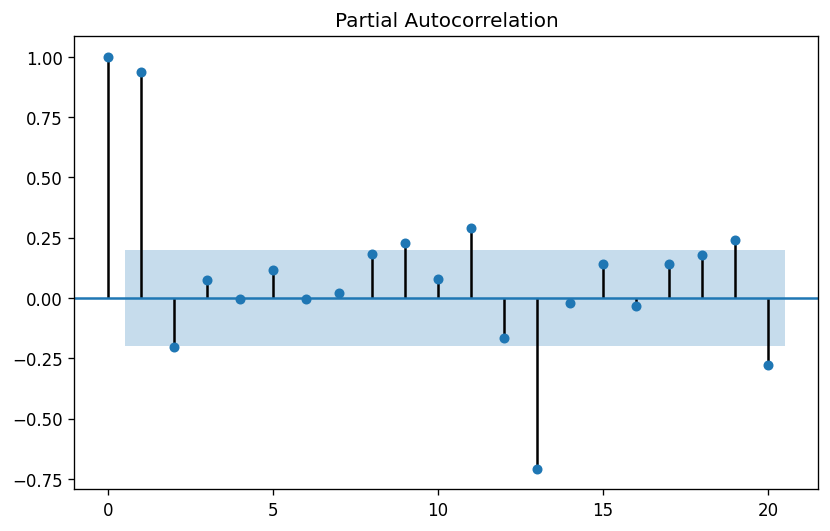

In [175]:
tsaplots.plot_acf(airlines.Passengers,lags=20)
tsaplots.plot_pacf(airlines.Passengers,lags=20)

In [176]:
# as the data has trend and seasonality, Holt Winters method should be chosen

In [177]:
# --> Simple Exponential smoothing
len(test)
ses_model=SimpleExpSmoothing(train.Passengers).fit()
ses_fcast=ses_model.forecast(24)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


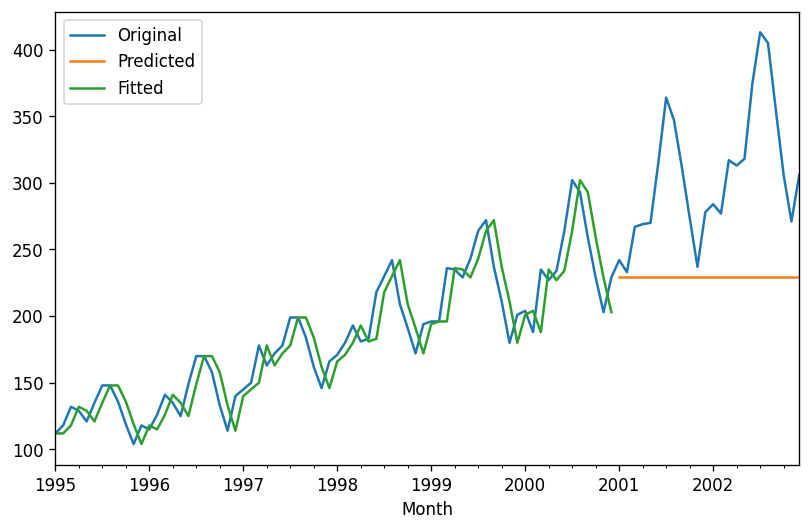

In [178]:
airlines.Passengers.plot(label='Original',legend=True)
ses_fcast.plot(label='Predicted',legend=True)
ses_model.fittedvalues.plot(label='Fitted',legend=True)

In [179]:
def MAPE(org,pred):
 t=(np.abs(org-pred)*100)/org
 return np.mean(t)

In [180]:
ses_mape=MAPE(test.Passengers,ses_fcast)
# --> Holts smoothing
holt_model_lin=Holt(train.Passengers).fit()
holt_fcast_lin=holt_model_lin.forecast(24)
holt_model_exp=Holt(train.Passengers,exponential=True).fit()
holt_fcast_exp=holt_model_exp.forecast(24)
holt_model_dam=Holt(train.Passengers,damped=True).fit()
holt_fcast_dam=holt_model_dam.forecast(24)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


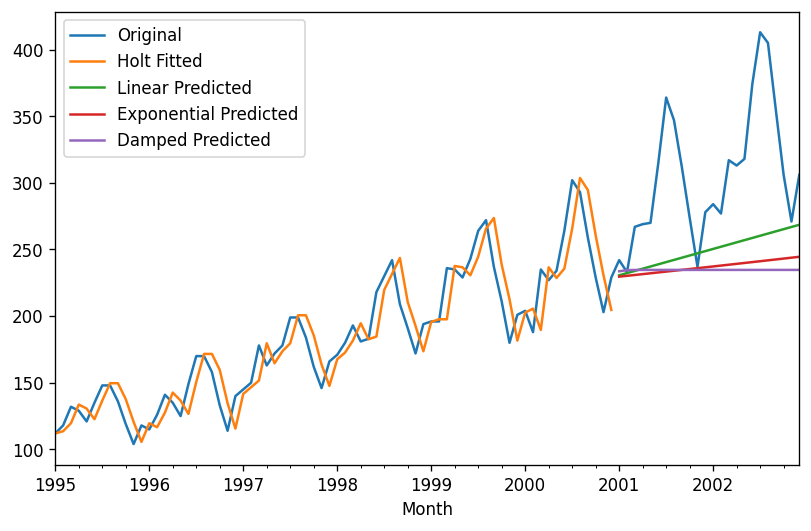

In [181]:
airlines.Passengers.plot(label='Original',legend=True)
holt_model_lin.fittedvalues.plot(label='Holt Fitted',legend=True)
holt_fcast_lin.plot(label='Linear Predicted',legend=True)
holt_fcast_exp.plot(label='Exponential Predicted',legend=True)
holt_fcast_dam.plot(label='Damped Predicted',legend=True)

In [182]:
holt_lin_mape=MAPE(test.Passengers,holt_fcast_lin)
holt_exp_mape=MAPE(test.Passengers,holt_fcast_exp)
holt_dam_mape=MAPE(test.Passengers,holt_fcast_dam)

In [183]:
# --> Holts Winters

In [185]:
hw_model=ExponentialSmoothing(train.Passengers,trend='multiplicative',seasonal='multiplicative',seasonal_periods=12).fit()
hw_fcast=hw_model.forecast(24)
hw_model_dam=ExponentialSmoothing(train.Passengers,trend='multiplicative',seasonal='multiplicative',seasonal_periods=12,damped=True).fit()
hw_fcast_dam=hw_model_dam.forecast(24)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


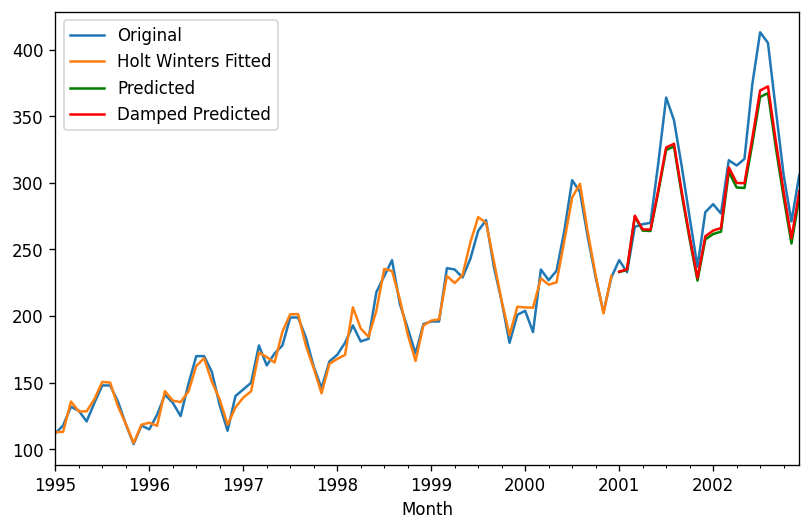

In [186]:
airlines.Passengers.plot(label='Original',legend=True)
hw_model.fittedvalues.plot(label='Holt Winters Fitted',legend=True)
hw_fcast.plot(label='Predicted',legend=True,color='green')
hw_fcast_dam.plot(label='Damped Predicted',legend=True,color='red')